In [245]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [246]:
# Parameters
L = 1.0  # Spatial domain
T = 0.5  # Time domain
c = 1.0  # Advection speed
N_ic = 100  # Initial condition points
N_bc = 100  # Boundary condition points
N_col = 1000  # Collocation points
epochs =  10000
learning_rate = 0.0005
loss_weights = [1.0, 5.0, 5.0]  # Weights for PDE, IC, BC losses

In [247]:
# Exact solution
def exact_solution(x, t):
    return np.exp(-100 * (((x - t) % L) - 0.2)**2)

In [279]:
# Neural Network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        scale = torch.tensor([L, T], dtype=torch.float32, device=x.device, requires_grad=False)
        inputs = 2.0 * inputs / scale - 1.0  # Normalize inputs
        return self.net(inputs)

In [280]:
# Loss function
def pinn_loss(model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc,weights):
    x_col, t_col = x_col.requires_grad_(True), t_col.requires_grad_(True)
    u = model(x_col, t_col)
    u_t = torch.autograd.grad(u, t_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    pde_residual = u_t + c * u_x
    loss_pde = loss_pde = weights[0] * torch.mean(pde_residual**2)

    u_ic_pred = model(x_ic, t_ic)
    loss_ic = weights[1] * torch.mean((u_ic_pred - u_ic)**2)

    u_bc_left = model(x_bc, t_bc)
    u_bc_right = model(torch.ones_like(x_bc) * L, t_bc)
    loss_bc = weights[2] * torch.mean((u_bc_left - u_bc_right)**2)

    return loss_pde + loss_ic + loss_bc, loss_pde, loss_ic, loss_bc

In [281]:
# Data preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_ic = torch.linspace(0, L, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic).to(device)
u_ic = torch.tensor(exact_solution(x_ic.cpu().numpy(), t_ic.cpu().numpy()), dtype=torch.float32).to(device)
x_bc = torch.zeros(N_bc, 1).to(device)
t_bc = torch.linspace(0, T, N_bc).reshape(-1, 1).to(device)

In [282]:
# Training
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)

In [283]:
# Store losses and metrics
loss_history = []
pde_loss_history = []
ic_loss_history = []
bc_loss_history = []
l2_error_history = []
pde_residual_history = []

start_time =  time.time()

In [284]:
# --- Training ---
model = PINN().to(device)

# Phase 1: Adam optimizer with LR decay
adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=500, gamma=0.8)

print("Training with Adam...")
for epoch in range(epochs):
    # Resample collocation points every 100 epochs
    if epoch % 100 == 0:
        x_col = torch.rand(N_col, 1).to(device) * L
        t_col = torch.rand(N_col, 1).to(device) * T

    adam.zero_grad()
    total_loss, loss_pde, loss_ic, loss_bc = pinn_loss(
        model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc, loss_weights
    )
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    adam.step()
    scheduler.step()

    # Store losses
    loss_history.append(total_loss.item())
    pde_loss_history.append(loss_pde.item())
    ic_loss_history.append(loss_ic.item())
    bc_loss_history.append(loss_bc.item())

    # Evaluate metrics every 100 epochs
    if epoch % 100 == 0:
        with torch.no_grad():
            x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
            t_test = torch.ones_like(x_test) * T
            u_pred = model(x_test, t_test)
            u_exact = torch.tensor(
                exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy()),
                dtype=torch.float32
            ).to(device)
            l2_error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
            l2_error_history.append(l2_error.item())

        # PDE residual
        x_res = torch.rand(1000, 1).to(device).requires_grad_(True) * L
        t_res = torch.rand(1000, 1).to(device).requires_grad_(True) * T
        u_res = model(x_res, t_res)
        u_t_res = torch.autograd.grad(u_res, t_res, grad_outputs=torch.ones_like(u_res), create_graph=True)[0]
        u_x_res = torch.autograd.grad(u_res, x_res, grad_outputs=torch.ones_like(u_res), create_graph=True)[0]
        pde_residual = torch.sqrt(torch.mean((u_t_res + c * u_x_res)**2))
        pde_residual_history.append(pde_residual.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4e}, "
              f"L2 Error: {l2_error.item():.4e}, PDE Residual: {pde_residual.item():.4e}")

# --- Phase 2: Switch to L-BFGS for fine-tuning ---
print("Switching to L-BFGS optimizer...")
lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=100)

def closure():
    lbfgs.zero_grad()
    total_loss, loss_pde, loss_ic, loss_bc = pinn_loss(
        model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc, loss_weights
    )
    total_loss.backward()
    return total_loss

# Run L-BFGS optimization
for _ in range(50):  # outer loop, each call may do multiple L-BFGS steps
    loss_val = lbfgs.step(closure)
    print(f"L-BFGS step, Loss: {loss_val.item():.4e}")

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Training with Adam...
Epoch 0, Total Loss: 2.6820e+00, L2 Error: 3.1505e-01, PDE Residual: 1.0382e+00
Epoch 1000, Total Loss: 4.1094e-01, L2 Error: 3.0535e-01, PDE Residual: 9.1230e-02
Epoch 2000, Total Loss: 3.3226e-01, L2 Error: 2.7795e-01, PDE Residual: 1.2300e-01
Epoch 3000, Total Loss: 2.4943e-01, L2 Error: 2.3320e-01, PDE Residual: 1.1084e-01
Epoch 4000, Total Loss: 2.1071e-01, L2 Error: 2.0967e-01, PDE Residual: 8.8769e-02
Epoch 5000, Total Loss: 1.9356e-01, L2 Error: 1.9898e-01, PDE Residual: 7.2309e-02
Epoch 6000, Total Loss: 1.8338e-01, L2 Error: 1.9357e-01, PDE Residual: 6.8520e-02
Epoch 7000, Total Loss: 1.7748e-01, L2 Error: 1.9051e-01, PDE Residual: 6.3650e-02
Epoch 8000, Total Loss: 1.7440e-01, L2 Error: 1.8853e-01, PDE Residual: 5.9012e-02
Epoch 9000, Total Loss: 1.7151e-01, L2 Error: 1.8746e-01, PDE Residual: 5.5899e-02
Switching to L-BFGS optimizer...
L-BFGS step, Loss: 1.6999e-01
L-BFGS step, Loss: 8.9915e-04
L-BFGS step, Loss: 8.9914e-04
L-BFGS step, Loss: 8.9914e-0

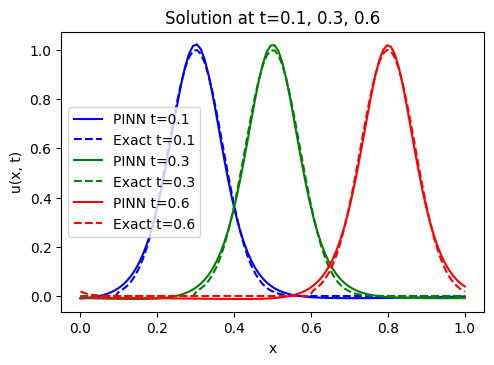

In [285]:
# Final evaluation at multiple time points
time_points = [0.1, 0.3, 0.6]
u_pred_list = []
u_exact_list = []
l2_errors = []
with torch.no_grad():
    x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
    for t_val in time_points:
        t_test = torch.ones_like(x_test) * t_val
        u_pred = model(x_test, t_test).cpu().numpy()
        u_exact = exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy())
        u_pred_list.append(u_pred)
        u_exact_list.append(u_exact)
        l2_error = np.sqrt(np.mean((u_pred - u_exact)**2))
        l2_errors.append(l2_error)

# Plotting results
plt.figure(figsize=(12, 8))

# Solution comparison at multiple time points
plt.subplot(2, 2, 1)
colors = ['blue', 'green', 'red']
for i, t_val in enumerate(time_points):
    plt.plot(x_test.cpu().numpy(), u_pred_list[i], color=colors[i], label=f'PINN t={t_val}')
    plt.plot(x_test.cpu().numpy(), u_exact_list[i], '--', color=colors[i], label=f'Exact t={t_val}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Solution at t=0.1, 0.3, 0.6')
plt.legend()


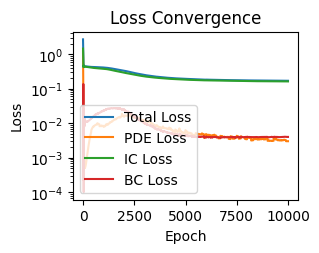

In [286]:
# Loss history
plt.subplot(2, 2, 2)
plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(ic_loss_history, label='IC Loss')
plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


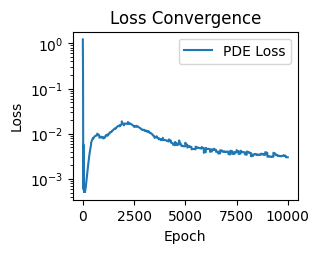

In [287]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
# plt.semilogy(ic_loss_history, label='IC Loss')
# plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


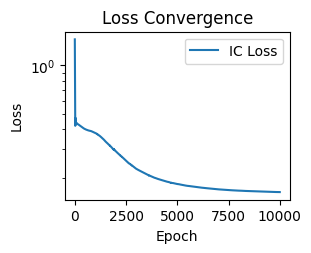

In [288]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
# plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(ic_loss_history, label='IC Loss')
# plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


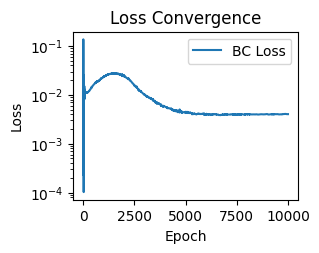

In [289]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
# plt.semilogy(pde_loss_history, label='PDE Loss')
# plt.semilogy(ic_loss_history, label='IC Loss')
plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


Text(0.5, 1.0, 'L2 Error vs. Epoch')

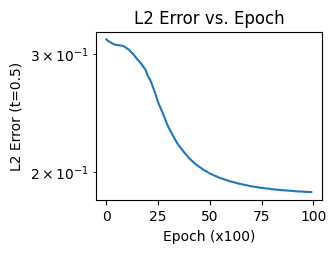

In [290]:

# L2 error history (at t=0.5)
plt.subplot(2, 2, 3)
plt.semilogy(l2_error_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('L2 Error (t=0.5)')
plt.title('L2 Error vs. Epoch')



Text(0.5, 1.0, 'PDE Residual vs. Epoch')

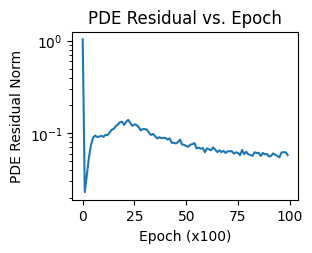

In [291]:
# PDE residual history
plt.subplot(2, 2, 4)
plt.semilogy(pde_residual_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('PDE Residual Norm')
plt.title('PDE Residual vs. Epoch')



In [292]:
plt.tight_layout()
plt.savefig('pinn_results.png')
plt.show()



<Figure size 640x480 with 0 Axes>

In [293]:
print("Final L2 Errors:")
for t_val, l2_error in zip(time_points, l2_errors):
    print(f"t={t_val}: {l2_error:.4e}")
print(f"Training Time: {training_time:.2f} seconds")

Final L2 Errors:
t=0.1: 1.2494e-02
t=0.3: 1.3485e-02
t=0.6: 1.4560e-02
Training Time: 58.61 seconds


   Epoch  Total Loss  PDE Loss   IC Loss   BC Loss
0      1    2.682007  1.219840  1.450942  0.011225
1      2    2.443943  1.078832  1.360779  0.004332
2      3    2.221762  0.946606  1.274437  0.000719
3      4    2.015409  0.823178  1.191875  0.000356
4      5    1.824774  0.708564  1.113071  0.003139
5      6    1.649749  0.602766  1.038043  0.008940
6      7    1.490226  0.505798  0.966817  0.017612
7      8    1.346056  0.417685  0.899418  0.028953
8      9    1.217018  0.338456  0.835887  0.042675
9     10    1.102796  0.268141  0.776289  0.058366
Loss breakdown saved to loss_breakdown.csv


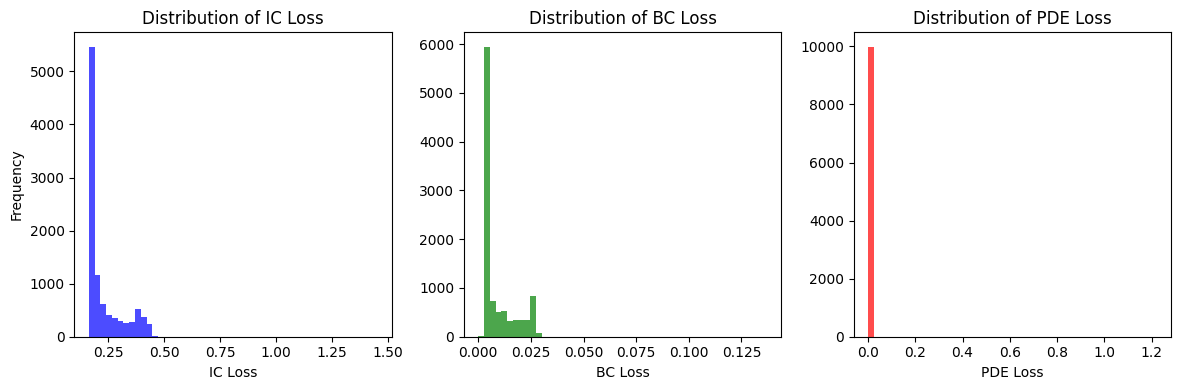

In [294]:
import pandas as pd

# Create a DataFrame for the losses
loss_df = pd.DataFrame({
    "Epoch": range(1, epochs + 1),
    "Total Loss": loss_history,
    "PDE Loss": pde_loss_history,
    "IC Loss": ic_loss_history,
    "BC Loss": bc_loss_history
})

# Show first 10 rows as a preview
print(loss_df.head(10))

# Save losses to CSV
loss_df.to_csv("loss_breakdown.csv", index=False)
print("Loss breakdown saved to loss_breakdown.csv")

# Plot histograms of the losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(ic_loss_history, bins=50, color='blue', alpha=0.7)
plt.xlabel("IC Loss")
plt.ylabel("Frequency")
plt.title("Distribution of IC Loss")

plt.subplot(1, 3, 2)
plt.hist(bc_loss_history, bins=50, color='green', alpha=0.7)
plt.xlabel("BC Loss")
plt.title("Distribution of BC Loss")

plt.subplot(1, 3, 3)
plt.hist(pde_loss_history, bins=50, color='red', alpha=0.7)
plt.xlabel("PDE Loss")
plt.title("Distribution of PDE Loss")

plt.tight_layout()
plt.savefig("loss_histograms.png")
plt.show()
